# Visualizing I/O

Running 3D Preprocessing

In [1]:
import os
os.chdir(r"C:\Users\jchen\Active Github Repositories\kits19-cnn")
import kits19cnn
os.chdir(r"C:\Users\jchen\Active Github Repositories")

In [4]:
from kits19cnn.io import Preprocessor
in_dir = r"C:\Users\jchen\kits19\data"
dset_dir = r"C:\Users\jchen\Desktop\Datasets\kits_preprocessed_isensee_spacing"
preprocess = Preprocessor(in_dir, dset_dir, kits_json_path=os.path.join(in_dir, "kits.json"),
                          with_mask=True)
preprocess.cases = preprocess.cases[:210]
print(f"Number of cases: {len(preprocess.cases)}")
preprocess.gen_data()

Number of cases: 210


100%|████████████████████████████████████████████████████████████████████████████████| 210/210 [52:09<00:00, 12.22s/it]


Running 2D Preprocessing

In [1]:
import os
os.chdir(r"C:\Users\jchen\Active Github Repositories\kits19-cnn")
import kits19cnn
os.chdir(r"C:\Users\jchen\Active Github Repositories")


In [3]:
from kits19cnn.io import Preprocessor
dset_dir = r"C:\Users\jchen\Desktop\Datasets\kits_preprocessed_isensee_spacing"
preprocess = Preprocessor(dset_dir, dset_dir, with_mask=True)
preprocess.save_dir_as_2d()

`kits_json_path is empty, so not resampling.`


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [04:35<00:00,  3.97s/it]


Saving the positive slice dictionary at C:\Users\jchen\Desktop\Datasets\kits_preprocessed_isensee_spacing\slice_indices.json.


Prepping experiment to fetch the i/o

In [2]:
from kits19cnn.experiments import TrainSegExperiment, TrainClfSegExperiment3D, \
                                  TrainSegExperiment2D, TrainClfSegExperiment2D, \
                                  seed_everything

def get_experiment(config):
    """
    Fetches experiment
    Args:
        config (dict): dictionary read from a yaml file
            i.e. experiments/finetune_classification.yml
    Returns:
        None
    """
    # setting up the train/val split with filenames
    seed = config["io_params"]["split_seed"]
    seed_everything(seed)
    mode = config["mode"].lower()
    assert mode in ["classification", "segmentation", "both"], \
        "The `mode` must be one of ['classification', 'segmentation', 'both']."
    if mode == "classification":
        raise NotImplementedError
    elif mode == "segmentation":
        if config["dim"] == 2:
            exp = TrainSegExperiment2D(config)
        elif config["dim"] == 3:
            exp = TrainSegExperiment(config)
        output_key = "logits"
    elif mode == "both":
        if config["dim"] == 2:
            exp = TrainClfSegExperiment2D(config)
        elif config["dim"] == 3:
            exp = TrainClfSegExperiment3D(config)
        output_key = ["seg_logits", "clf_logits"]

    print(f"Seed: {seed}\nMode: {mode}")
    return exp

pyarrow not available, switching to pickle. To install pyarrow, run `pip install pyarrow`.


In [16]:
%%file "C:\\Users\\jchen\\Active Github Repositories\\train_2d.yml"

  mode: segmentation # classification # both
  dim: 2
  data_folder: C:\\Users\\jchen\\Desktop\\Datasets\\kits_preprocessed_isensee_spacing

  runner_params:
    logdir: C:\\Users\\jchen
    num_epochs: 85
    fp16: False
    verbose: True

  io_params:
    test_size: 0.2
    split_seed: 200
    batch_size: 16
    num_workers: 0
    aug_key: aug7
    file_ending: .npy
    slice_indices_path: C:\\Users\\jchen\\Desktop\\Datasets\\kits_preprocessed_isensee_spacing\\slice_indices.json # 2D
    p_pos_per_sample: 0.8 # 2D

  criterion_params:
    loss: ce_dice_loss
    ce_dice_loss:
      soft_dice_kwargs:
        batch_dice: True
        smooth: 0.00001 #1e-5
        do_bg: False
        square: False
      ce_kwargs: {}
    # for clf_seg
    # seg_loss: ce_dice_loss
    # ce_dice_loss:
      # soft_dice_kwargs:
      #   batch_dice: True
        # smooth: 0.00001 #1e-5
      #   do_bg: False
      #   square: False
      # ce_kwargs: {}
    # clf_loss: bce_dice_loss
    # bce_dice_loss:
      # eps: 0.0000001 # 1e-7
      # activation: sigmoid

  model_params:
    architecture: nnunet
    nnunet:
      input_channels: 1
      base_num_features: 30
      num_classes: 3
      num_pool: 6
      num_conv_per_stage: 2
      feat_map_mul_on_downscale: 2
      deep_supervision: False
      convolutional_pooling: True
      convolutional_upsampling: True
      max_num_features: 320
      classification: False #True
      dropout_op_kwargs:
        p: 0
        inplace: True
    ## 2D ONLY
    # encoder: resnet34
    # unet_smp:
    #   attention_type: ~ # scse
    #   decoder_use_batchnorm: True # inplace for InplaceABN
    # fpn_smp:
    #   dropout: 0.2

  opt_params:
    opt: SGD
    SGD:
      lr: 0.0001
      momentum: 0.9
      weight_decay: 0.0001
    scheduler_params:
      scheduler: ReduceLROnPlateau
      ReduceLROnPlateau:
        factor: 0.15
        patience: 30 #2
        mode: min
        verbose: True
        threshold: 0.001
        threshold_mode: abs

  callback_params:
    # ppvtprf1:
    #   num_classes: 3
    #   threshold: 0.5
    #   activation: Softmax
    earlystop:
      patience: 60
      min_delta: 0.001
    # accuracy:
    #   threshold: 0.5
    #   activation: Softmax
    checkpoint_params:
      checkpoint_path: ~ #/content/logs/segmentation/checkpoints/last.pth #/content/logs/segmentation/checkpoints/last_full.pth
      mode: model_only


Overwriting C:\\Users\\jchen\\Active Github Repositories\\train_2d.yml


In [17]:
import yaml
import argparse

yml_path = "C:\\Users\\jchen\\Active Github Repositories\\train_2d.yml"

with open(yml_path, 'r') as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

exp = get_experiment(config)


Splitting the dataset normally...
Train Transforms: [SpatialTransform( p_rot_per_sample = 0.2, p_scale_per_sample = 0.2, p_el_per_sample = 0.2, data_key = 'data', label_key = 'seg', patch_size = (256, 256), patch_center_dist_from_border = (30, 30, 30), do_elastic_deform = True, alpha = (0.0, 900.0), sigma = (9.0, 13.0), do_rotation = True, angle_x = (-0.2617993877991494, 0.2617993877991494), angle_y = (-0.2617993877991494, 0.2617993877991494), angle_z = (-0.2617993877991494, 0.2617993877991494), do_scale = True, scale = (0.85, 1.25), border_mode_data = 'constant', border_cval_data = 0, order_data = 3, border_mode_seg = 'constant', border_cval_seg = 0, order_seg = 0, random_crop = False ), MirrorTransform( data_key = 'data', label_key = 'seg', axes = (0, 1) ), GammaTransform( p_per_sample = 0.3, retain_stats = True, per_channel = True, data_key = 'data', gamma_range = (0.7, 1.5), invert_image = False ), BrightnessTransform( p_per_sample = 0.3, data_key = 'data', mu = 101, sigma = 76.9, 

In [18]:
# train_dset = exp.train_dset
# print(f"Length of data loader: {len(train_dset)}")
# i = 2
# batch = train_dset[i]
# print(batch[0].shape, batch[1].shape)
# all_arr = [arr for arr in train_dset]
# print(len(all_arr))

In [19]:
train_loader = exp.loaders["train"]
print(f"Length of data loader: {len(train_loader)}")
for idx, batch in enumerate(train_loader):
    batch_x, batch_y = batch
    if idx > 0:
        break
batch_x.shape, batch_y.shape

Length of data loader: 3


(torch.Size([16, 1, 256, 256]), torch.Size([16, 1, 256, 256]))

Visualization

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_scan(scan, mask, start_with, show_every, rows=3, cols=3):
    """
    Plots multiple scans throughout your medical image.
    Args:
        scan: numpy array with shape (x,y,z)
        start_with: slice to start with
        show_every: size of the step between each slice iteration
        rows: rows of plot
        cols: cols of plot
        box:
    Returns:
        a plot of multiple scans from the same image
    """
    fig,ax = plt.subplots(rows, cols, figsize=[4*cols, 4*rows])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/cols), int(i%cols)].set_title('slice %d' % ind)
        ax[int(i/cols), int(i%cols)].axis('off')

        ax[int(i/cols), int(i%cols)].imshow(scan[ind], cmap='gray')
        ax[int(i/cols), int(i%cols)].imshow(mask[ind], cmap='jet', alpha=0.5)
    plt.show()

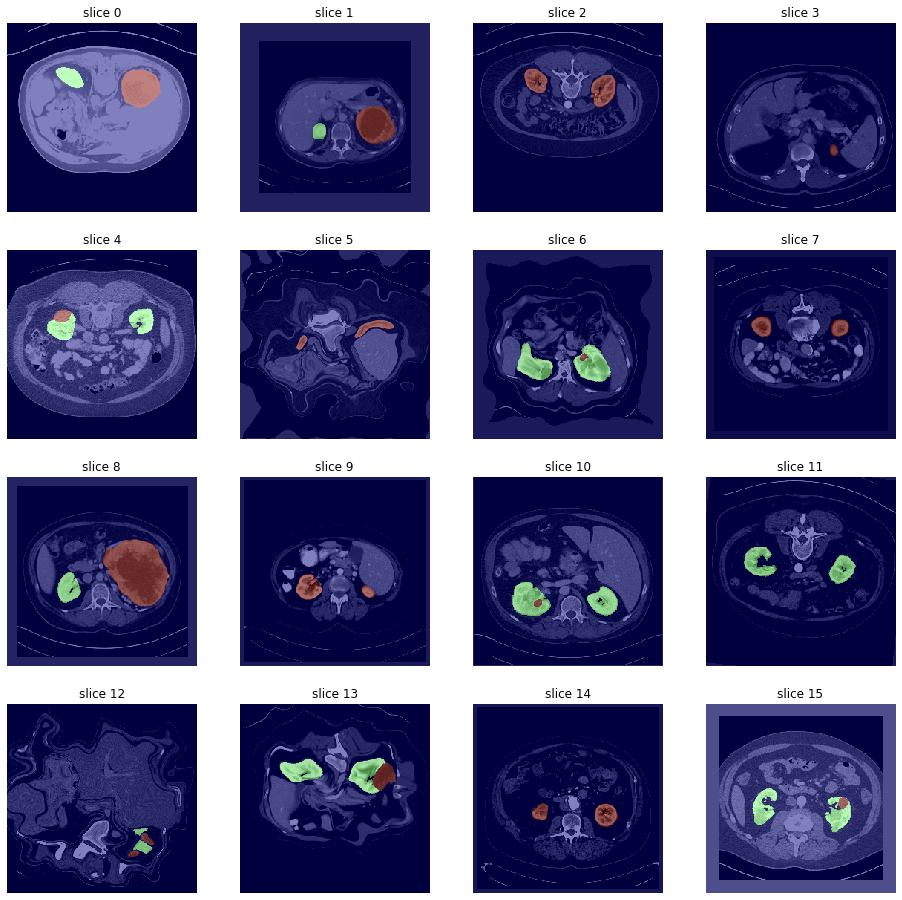

In [24]:
x, y = batch_x.cpu().detach().numpy().squeeze(), batch_y.cpu().detach().numpy().squeeze()
plot_scan(x, y, start_with=0, show_every=1, rows=4, cols=4)

# Predictions v. Input Volumes
* case 5: 1 kidney
* case 6: small tumor + missed tumor completely
* case 36: small tumor + missed completely
* case 39: small tumor + missed completely with false positive on wrong kidney
* case 75: big tumor + did well
* case 82: small tumor + missed it
* case 93: small tumor + half missed it (predicted half on top of left kidney and half on bottom of left kidney)
* case 113: big tumor + did well (lots of small components here and there)
<hr/>
Conclusion:
* Sample more smaller tumor cases
* threshold out smaller components

In [5]:
from glob import glob
dset_dir = r"C:\Users\jchen\Desktop\Datasets\kits_preprocessed_isensee_spacing"
pred_dir = r"C:\Users\jchen\Desktop\kits19_predictions"
cases = glob(os.path.join(dset_dir, "*/"), recursive=True)
cases_pred = glob(os.path.join(pred_dir, "*/"), recursive=True)

len(cases), len(cases_pred)

(210, 21)

In [6]:
from pathlib import Path
def to_cases(case_list):
    return [Path(case).name for case in case_list]
cases_list = to_cases(cases)
cases_pred_list = to_cases(cases_pred)
cases_match = [case for case in cases_list if case in cases_pred_list]
len(cases_match), cases_match

(21,
 ['case_00005',
  'case_00006',
  'case_00036',
  'case_00039',
  'case_00046',
  'case_00047',
  'case_00071',
  'case_00075',
  'case_00076',
  'case_00082',
  'case_00089',
  'case_00093',
  'case_00113',
  'case_00115',
  'case_00116',
  'case_00122',
  'case_00169',
  'case_00172',
  'case_00187',
  'case_00193',
  'case_00208'])

In [16]:
i = 113
case = f"case_{i:05d}"
# case = "case_%05d"%i
case

'case_00113'

In [22]:
import os
import numpy as np

i = 113
dset_dir = r"C:\Users\jchen\Desktop\Datasets\kits_preprocessed_isensee_spacing"
case = f"case_{i:05d}"
image = np.load(os.path.join(dset_dir, case, "imaging.npy")).squeeze()
mask = np.load(os.path.join(dset_dir, case, "segmentation.npy")).squeeze()

print(f"Case: {case}; Shape: {image.shape}")
assert mask.shape == image.shape
import ipyvolume as ipv
ipv.quickvolshow(mask)

Case: case_00113; Shape: (67, 222, 222)


In [23]:
import os
import numpy as np

pred_dir = r"C:\Users\jchen\Desktop\kits19_predictions"
case = f"case_{i:05d}"
pred = np.load(os.path.join(pred_dir, case, "pred.npy")).squeeze()
# mask = np.load(os.path.join(dset_dir, case, "segmentation.npy")).squeeze()

print(f"Case: {case}; Shape: {pred.shape}")
import ipyvolume as ipv
ipv.quickvolshow(pred)

Case: case_00113; Shape: (66, 221, 221)
